# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>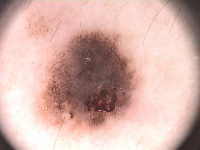</td><td>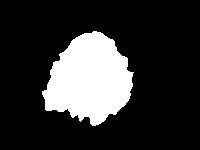</td></tr></table>

2. Разархивируем .rar файл.
Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [ ]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

In [ ]:
!unrar x PH2Dataset.rar

In [ ]:
!ls -l

In [ ]:
import os
print(os.listdir("PH2Dataset"))  # Смотрим содержимое папки PH2Dataset

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
import os
root = 'PH2Dataset'
target_dir = os.path.join(root, 'PH2 Dataset images')

# Проверяем, существует ли папка
if not os.path.exists(target_dir):
    print(f"Ошибка: Папка {target_dir} не найдена!")
else:
    print("Папка найдена. Пример содержимого:")
    # Выводим первые 5 подпапок
    for i, (root_dir, dirs, files) in enumerate(os.walk(target_dir)):
        if i >= 5:
            break
        print(f"Папка: {root_dir}")
        print(f"Подпапки: {dirs[:3]}...")  # Первые 3 подпапки
        print(f"Файлы: {files[:3]}...\n")  # Первые 3 файла

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Изменим их размер на $256\times256 $ пикселей

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

## PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Метрика

## IoU (intersection over union)

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

In [ ]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

## SegNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class ConvReLU(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding)
        self.bn = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1) -> None:
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvReLU(in_c if i == 0 else out_c, out_c, kernel_size, padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, ind = self.pool(x)
        return x, ind

class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c, depth=2, kernel_size=3, padding=1, classification=False) -> None:
        super(DecoderBlock, self).__init__()
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.layers = nn.ModuleList()
        for i in range(depth):
            if i == depth - 1 and classification:
                self.layers.append(nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding))
            elif i == depth - 1:
                self.layers.append(ConvReLU(in_c, out_c, kernel_size=kernel_size, padding=padding))
            else:
                self.layers.append(ConvReLU(in_c, in_c, kernel_size=kernel_size, padding=padding))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # Encoder (VGG-16 like architecture)
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        self.encoder5 = EncoderBlock(512, 512)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            ConvReLU(512, 512),
            ConvReLU(512, 512)
        )

        # Decoder (upsampling)
        self.decoder5 = DecoderBlock(512, 512)
        self.decoder4 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder2 = DecoderBlock(128, 64)
        self.decoder1 = DecoderBlock(64, out_channels, classification=True)

    def forward(self, x):
        # Encoder
        x, ind1 = self.encoder1(x)
        x, ind2 = self.encoder2(x)
        x, ind3 = self.encoder3(x)
        x, ind4 = self.encoder4(x)
        x, ind5 = self.encoder5(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        x = self.decoder5(x, ind5)
        x = self.decoder4(x, ind4)
        x = self.decoder3(x, ind3)
        x = self.decoder2(x, ind2)
        x = self.decoder1(x, ind1)

        return x  

## Тренировка 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm  

In [ ]:
def evaluate(model, data_loader, criterion, device) :
    model.eval()
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, masks in data_loader:
            batch_size = images.size(0)  # Получаем размер текущего батча
            total_samples += batch_size

            images = images.to(device)
            masks = masks.to(device).float()  # Убедимся, что маски float

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)

    avg_loss = running_loss / total_samples

    return avg_loss

In [ ]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs: int = 25,
    scheduler: optim.lr_scheduler._LRScheduler = None,
    save_path: str = 'best_model.pth'
) -> tuple:

    best_loss = float('inf')
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        

        # Training phase
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate epoch training loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Validation phase
        val_loss = evaluate(model, val_loader, criterion, device)
        val_loss_history.append(val_loss)

        # Update learning rate scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Val Loss: {val_loss:.4f}')

    return train_loss_history, val_loss_history

In [ ]:
segnet_model_bce = SegNet().to(device)
segnet_criterion_bce = nn.BCEWithLogitsLoss()
segnet_optimizer_bce = optim.Adam(segnet_model_bce.parameters(), lr=0.00001)
segnet_scheduler_bce = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer_bce, 'min', patience=3)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
BCE_segnet_history = train(segnet_model_bce, 
                           train_dataloader, 
                           valid_dataloader, 
                           segnet_criterion_bce, 
                           segnet_optimizer_bce, 
                           device, 
                           scheduler=segnet_scheduler_bce
                          )

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_history, val_history, title='Unet: BCELoss'):

    plt.figure(figsize=(10, 6))
    plt.plot(train_history, label='Train Loss', color='blue', alpha=0.7)
    plt.plot(val_history, label='Validation Loss', color='red', alpha=0.7)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Добавляем точки для лучшей читаемости
    plt.scatter(range(len(train_history)), train_history, color='blue', s=15)
    plt.scatter(range(len(val_history)), val_history, color='red', s=15)
    
    plt.show()

In [ ]:
plot_training_history(BCE_segnet_history[0], BCE_segnet_history[1], title='SegNet: BCEloss')

## Инференс

In [ ]:
def test(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device
) -> tuple:

    model.eval()
    running_loss = 0.0
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, masks in data_loader:
            images = images.to(device)
            masks = masks.to(device).float()  # Убедимся, что маски float

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)

            # Применяем sigmoid и вычисляем IoU
            preds = torch.sigmoid(outputs)
            iou = calculate_iou(preds, masks)
            total_iou += iou * images.size(0)
            total_samples += images.size(0)

    avg_loss = running_loss / total_samples
    avg_iou = total_iou / total_samples

    return avg_loss, avg_iou

In [ ]:
avg_iou= test(segnet_model_bce, test_dataloader, segnet_criterion_bce, device)[1]
print(f"IoU на тесте: {avg_iou}")

## Дополнительные функции потерь 

### Dice Loss

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    # Бинаризуем предсказания с помощью порога
    probs = torch.sigmoid(logits)
    preds = (probs > threshold).float()
    preds = probs
    # Вычисляем матрицу ошибок
    true_pos = (preds * labels).sum()
    false_pos = (preds * (1 - labels)).sum()
    false_neg = ((1 - preds) * labels).sum()

    # Вычисляем Dice коэффициент
    dice = (2 * true_pos) / (2 * true_pos + false_pos + false_neg + 1e-8)  # Добавляем эпсилон для стабильности

    return dice

In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.segmentation import GeneralizedDiceScore

In [ ]:
dice = GeneralizedDiceScore(num_classes=1, include_background=True,).to(device)
torch_dice_score = dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))
torch_dice_score.item()

In [ ]:
my_dice_score = dice_score(dummpy_sample['logits'], dummpy_sample['labels'].to(int))
my_dice_score.item()

In [ ]:
assert(torch_dice_score == my_dice_score)

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):
    '''
    Это лосс.
    '''
    probs = torch.sigmoid(logits)
    # Вычисляем пересечение и объединение
    intersection = (probs * labels).sum(dim=(2,3))
    cardinality = (probs + labels).sum(dim=(2,3))

    # Dice score для каждого класса
    dice = (2 * intersection) / (cardinality + 1e-6)

    # Dice loss = 1 - средний Dice score
    return 1 - dice.mean()

Проверка на корректность:

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
from segmentation_models_pytorch.losses import DiceLoss

dice_loss_torch = DiceLoss(mode='binary')
torch_dice = dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])
torch_dice.item()

In [ ]:
my_dice = dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])
my_dice.item()

Как видим, результаты немного различны, поэтому assert вызывает ошибку.

In [ ]:
assert torch_dice == my_dice

In [ ]:
assert np.isclose(torch_dice.item(), my_dice.item())

Тем не менее, результаты совпадают в пределах допустимой погрешности


### Focal Loss

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    preds = torch.sigmoid(y_pred)
    loss = -(1 - (preds * y_real + (1 - preds) * (1 - y_real))) ** gamma * (y_real * torch.log(preds) + (1 - y_real) * torch.log(1 - preds))
    return loss.sum()

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
torch_focal_loss = sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum').item()
torch_focal_loss

In [ ]:
my_focal_loss = focal_loss(dummpy_sample['labels'], dummpy_sample['logits']).item()
my_focal_loss

In [ ]:
assert torch_focal_loss == my_focal_loss

In [ ]:
assert np.isclose(torch_focal_loss, my_focal_loss)

## Обучение SegNet на новых лоссах

***Обучение SegNet на Dice-лоссе***

In [ ]:
segnet_model_dice = SegNet().to(device)
segnet_criterion_dice = DiceLoss(mode='binary')
segnet_optimizer_dice = optim.Adam(segnet_model_dice.parameters(), lr=0.0001, weight_decay=1e-3)
segnet_scheduler_dice = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer_dice, 'min', patience=3)

In [ ]:
DICE_segnet_history = train(segnet_model_dice, 
                            train_dataloader, 
                            valid_dataloader, 
                            segnet_criterion_dice, 
                            segnet_optimizer_dice, 
                            device, 
                            scheduler=segnet_scheduler_dice
                           )

In [ ]:
plot_training_history(DICE_segnet_history[0], DICE_segnet_history[1], title='SegNet: DICEloss')

In [ ]:
dice_avg_iou= test(segnet_model_dice, test_dataloader, segnet_criterion_dice, device)[1]
print(f"Метрика IoU на тесте при Dice loss = {dice_avg_iou}")

***Обучение SegNet на Focal-лоссе***

In [ ]:
segnet_model_focal = SegNet().to(device)
segnet_criterion_focal = FocalLoss(mode='binary')
segnet_optimizer_focal = optim.Adam(segnet_model_focal.parameters(), lr=0.00001, weight_decay=1e-3)
segnet_scheduler_focal = optim.lr_scheduler.ReduceLROnPlateau(segnet_optimizer_focal, 'min', patience=3)

In [ ]:
FOCAL_segnet_history = train(segnet_model_focal, 
                             train_dataloader, 
                             valid_dataloader, 
                             segnet_criterion_focal, 
                             segnet_optimizer_focal, 
                             device, 
                             scheduler=segnet_scheduler_focal
                            )

In [ ]:
plot_training_history(FOCAL_segnet_history[0], FOCAL_segnet_history[1], title='SegNet: FOCALloss')

In [ ]:
focal_avg_iou= test(segnet_model_focal, test_dataloader, segnet_criterion_focal, device)[1]
print(f"IoU на тесте при Dice loss = {focal_avg_iou}")

**Какая модель быстрее сходится? Визуализируем графики валидации для трех лоссов**

In [ ]:
def plot_losses_histories(bce_history, dice_history, focal_history, title='BCE, Dice and Focal losses'):

    plt.figure(figsize=(10, 6))
    plt.plot(bce_history, label='BCE val Loss', color='blue', alpha=0.7)
    plt.plot(dice_history, label='Dice val Loss', color='red', alpha=0.7)
    plt.plot(focal_history, label='Focal val Loss', color='green', alpha=0.7)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Добавляем точки для лучшей читаемости
    plt.scatter(range(len(bce_history)), bce_history, color='blue', s=15)
    plt.scatter(range(len(dice_history)), dice_history, color='red', s=15)
    plt.scatter(range(len(focal_history)), focal_history, color='green', s=15)
    
    plt.show()

In [ ]:
plot_losses_histories(BCE_segnet_history[1], DICE_segnet_history[1], FOCAL_segnet_history[1])

*Как видим, BCEloss сходится быстрее*

**При каком лоссе модель выдает наилучшую метрику?** *Focal loss*

In [ ]:
print(f"Метрика IoU на тесте при BCE loss = {avg_iou}")
print(f"Метрика IoU на тесте при Dice loss = {dice_avg_iou}")
print(f"Метрика IoU на тесте при Focal loss = {focal_avg_iou}")

In [ ]:
bce_avg_iou= test(segnet_model_bce, test_dataloader, segnet_criterion_bce, device)[0]
dice_avg_iou= test(segnet_model_dice, test_dataloader, segnet_criterion_dice, device)[0]
focal_avg_iou= test(segnet_model_focal, test_dataloader, segnet_criterion_focal, device)[0]

print(f"loss на тесте при BCE loss = {bce_avg_iou}")
print(f"loss на тесте при Dice loss = {dice_avg_iou}")
print(f"loss на тесте при Focal loss = {focal_avg_iou}")

# Новая модель!

## U-Net 

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
        # Инициализация весов
        for m in self.double_conv:
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear: #тут используем билинейную интерполяцию в качестве upsampling
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2): # x2 - тензор из skip-connection
        x1 = self.up(x1)

        # input is (batch_size, C, H, W)
        diffY = x2.size()[2] - x1.size()[2] # разница по высоте
        diffX = x2.size()[3] - x1.size()[3] # разница по ширине

        # симметричный паддинг, чтобы размеры по краям совпали
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,  # padding по ширине (слева и справа)
                        diffY // 2, diffY - diffY // 2]) # padding по высоте (сверху и снизу)

        x = torch.cat([x2, x1], dim=1) # объединить по канальному измерению (dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
import torch.nn.init as init

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
        # Инициализация последнего слоя
        init.normal_(self.outc.conv.weight, mean=0, std=0.01)
        if self.outc.conv.bias is not None:
            init.constant_(self.outc.conv.bias, 0)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## Обучение UNet

In [ ]:
from torch import optim

In [ ]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    num_epochs: int = 25,
    scheduler: optim.lr_scheduler._LRScheduler = None,
    save_path: str = 'best_model_.pth'
) -> tuple:

    best_loss = float('inf')
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        

        # Training phase
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate epoch training loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Validation phase
        val_loss = evaluate(model, val_loader, criterion, device)
        val_loss_history.append(val_loss)

        # Update learning rate scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), save_path)

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_loss:.4f} | '
              f'Val Loss: {val_loss:.4f}')

    return train_loss_history, val_loss_history

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
import torch.nn as nn
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.losses import FocalLoss

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
from tqdm import tqdm

***Обучение Unet на BCE-лоссе***

In [ ]:
BCE_criterion = nn.BCEWithLogitsLoss()

In [ ]:
unet_model_bce = UNet(bilinear=True).to(device)
unet_optimizer_bce = optim.Adam(unet_model_bce.parameters(), lr=0.00001)
unet_scheduler_bce = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer_bce, 'min', patience=3)

In [ ]:
BCE_unet_history = train(unet_model_bce, 
                         train_dataloader, 
                         valid_dataloader, 
                         BCE_criterion, 
                         unet_optimizer_bce, 
                         device, 
                         scheduler=unet_scheduler_bce
                        )

In [ ]:
plot_training_history(BCE_unet_history[0], BCE_unet_history[1])

***Обучение Unet на DICE - лоссе***

In [ ]:
Dice_criterion = DiceLoss(mode='binary')

In [ ]:
unet_model_dice = UNet(bilinear=True).to(device)
unet_optimizer_dice = optim.Adam(unet_model_dice.parameters(), lr=1e-5, weight_decay=1e-5)
unet_scheduler_dice = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer_dice, 'min', patience=3)

In [ ]:
DICE_unet_history = train(unet_model_dice, 
                          train_dataloader, 
                          valid_dataloader, 
                          Dice_criterion, 
                          unet_optimizer_dice, 
                          device, 
                          scheduler=unet_scheduler_dice)

In [ ]:
plot_training_history(DICE_unet_history[0], DICE_unet_history[1], title='Unet: DICE Loss')

***Обучение Unet на FOCAL - лоссе***

In [ ]:
Focal_criterion = FocalLoss(mode='binary', alpha=1)

In [ ]:
unet_model_focal = UNet(bilinear=True).to(device)
unet_optimizer_focal = optim.Adam(unet_model_focal.parameters(), lr=1e-4, weight_decay=1e-5)
unet_scheduler_focal = optim.lr_scheduler.ReduceLROnPlateau(unet_optimizer_focal, 'min', patience=3)

In [ ]:
FOCAL_unet_history = train(unet_model_focal, 
                           train_dataloader, 
                           valid_dataloader, 
                           Focal_criterion, 
                           unet_optimizer_focal, 
                           device, 
                           scheduler=unet_scheduler_focal)

In [ ]:
plot_training_history(FOCAL_unet_history[0], FOCAL_unet_history[1], title='Unet: FOCAL Loss')

In [ ]:
bce_avg_iou_unet= test(unet_model_bce, test_dataloader, BCE_criterion, device)[1]
dice_avg_iou_unet= test(unet_model_dice, test_dataloader, Dice_criterion, device)[1]
focal_avg_iou_unet= test(unet_model_focal, test_dataloader, Focal_criterion, device)[1]

print(f"Метрика IoU на тесте при BCE loss = {bce_avg_iou_unet}")
print(f"Метрика IoU на тесте при Dice loss = {dice_avg_iou_unet}")
print(f"Метрика IoU на тесте при Focal loss = {focal_avg_iou_unet}")

**Лучшее значение метрики IoU для Unet: 0.763**

**Лучшее значение метрики IoU для SegNet: 0.785**

In [ ]:
bce_avg_loss_unet= test(unet_model_bce, test_dataloader, BCE_criterion, device)[0]
dice_avg_loss_unet= test(unet_model_dice, test_dataloader, Dice_criterion, device)[0]
focal_avg_loss_unet= test(unet_model_focal, test_dataloader, Focal_criterion, device)[0]

print(f"Loss на тесте при BCE loss = {bce_avg_loss_unet}")
print(f"Loss на тесте при Dice loss = {dice_avg_loss_unet}")
print(f"Loss на тесте при Focal loss = {focal_avg_loss_unet}")

**Лучший лосс segnet: 0.065**

**Лучший лосс unet: 0.0098**

# Визуальное сравнение обучения двух моделей 

**BCELoss** - как видим, на SegNet лосс на валидации падает намного быстрее и чуть более шумно (lr одинаковый)

In [ ]:
plot_training_history(BCE_segnet_history[0], BCE_segnet_history[1], title='SegNet: BCEloss')

In [ ]:
plot_training_history(BCE_unet_history[0], BCE_unet_history[1])

**Dice Loss** - лосс SegNet падает намного быстрее и график менее шумный

In [ ]:
plot_training_history(DICE_segnet_history[0], DICE_segnet_history[1], title='SegNet: DICEloss')

In [ ]:
plot_training_history(DICE_unet_history[0], DICE_unet_history[1], title='Unet: DICE Loss')

**Focal loss** - опять лосс SegNet падает быстрее 

In [ ]:
plot_training_history(FOCAL_segnet_history[0], FOCAL_segnet_history[1], title='SegNet: FOCALloss')

In [ ]:
plot_training_history(FOCAL_unet_history[0], FOCAL_unet_history[1], title='Unet: FOCAL Loss')